In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import pdb
import h5py

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pdb
from scipy.misc import imsave

Automatic pdb calling has been turned ON


In [3]:
#load hdf5 data

path2dat = '/media/songbird/Data/deep_learn_data/'
filnam = path2dat+'song_data.hdf5'

f = h5py.File(filnam,'r')

dset = f[u'songdata']

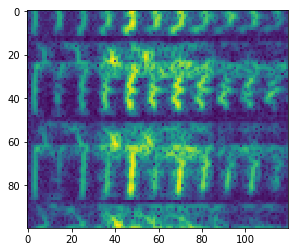

In [4]:
plt.imshow(dset[1000:1100,:])

In [39]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        #encoder
        self.fe1 = nn.Linear(datadim, 100)
        self.fe1b = nn.BatchNorm1d(100)
        self.fe2 = nn.Linear(100,60)
        #self.fe2d = nn.Dropout(0.2)
        self.fe3 = nn.Linear(60,30)
        self.fe3b = nn.BatchNorm1d(30)
        self.fe4_mu = nn.Linear(30,nz)
        self.fe4_sigma = nn.Linear(30,nz)
        
        #decoder
        self.fd1 = nn.Linear(nz,30)
        self.fd1b = nn.BatchNorm1d(30)
        
        self.fd2 = nn.Linear(30, 60)
        #self.fd2d = nn.Dropout(0.2)
        self.fd3 = nn.Linear(60,100)
        self.fd3b = nn.BatchNorm1d(100)
        
        self.fd4_mu = nn.Linear(100, datadim)
        self.fd4_sigma = nn.Linear(100,1)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        #h1 = self.fe1b(self.relu(self.fe1(x)) )
        #h2 = self.relu(self.fe2( h1 ) )
        #h3 = self.fe3b(self.relu(self.fe3( self.fe2d( h2 ))) )
        
        h1 = self.fe1b(self.tanh(self.fe1(x)) )
        h2 = self.tanh(self.fe2( h1 ) )
        h3 = self.fe3b(self.tanh(self.fe3( h2 )) )
        return self.fe4_mu(h3), self.fe4_sigma(h3) #this supposed to be (mu,log(variance))

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if cudaa:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu) # this the value of z

    def decode(self, z):
        #pdb.set_trace()
        #h1 = self.fd1b( self.relu(self.fd1(z)) )
        #h2 = self.fd2d( self.relu(self.fd2(h1)) )
        #h3 = self.fd3b( self.relu( self.fd3( h2 ) ) )
        h1 = self.fd1b( self.tanh(self.fd1(z)) )
        h2 = self.tanh(self.fd2(h1)) 
        h3 = self.fd3b( self.tanh( self.fd3( h2 ) ) )
        return self.fd4_mu(h3),self.fd4_sigma(h3) #this is the again (mu_x_given_z , logvariance(x given z)))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, datadim))
        z = self.reparametrize(mu, logvar)
        out_mu, out_logvar = self.decode(z)
        return out_mu, out_logvar, mu, logvar

In [62]:
def loss_function(recon_x_mu,recon_x_sigma, x, mu, logvar):
    MSE = recon_x_mu - x
    MSE = MSE.pow(2)
    MSE = torch.sum(MSE,1)
    
    invsig = -0.5/recon_x_sigma.exp_()
    
    MSE = MSE*invsig - 0.5*recon_x_sigma - np.log(np.sqrt(2*np.pi))
    MSE = torch.sum(MSE)
             
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    
    LOSS = MSE.add_(KLD)#.mul_(Nsamp/minibatchSize)
    return LOSS

In [63]:
#parameters
datadim = 120
nz = 6

#do gpu?
cudaa = 1

outpathsamples = path2dat+'/samples/'

#number of batches after which to display loss
log_interval = 100



In [64]:
#divide data into K batches
N = dset.shape[0]

#how many batches?
K = 10000


minibatchSize = 300

#make batches
nperbatch = np.floor(N/K) #samples per batch
nperbatch = nperbatch.astype('int32')
print(nperbatch)

#batches
batchess = np.arange(start = 0,stop = nperbatch*K, step = nperbatch)
np.random.shuffle(batchess)

28023


In [65]:
#INSTANTIATE MODEL
model = VAE()
if cudaa:
    model.cuda()

#reconstruction_function = nn.MSELoss()
#reconstruction_function.size_average = False

#optimizer = optim.Adam(model.parameters(), lr=1e-4, betas = (0.6,0.999), weight_decay  = 0.001)
optimizer = optim.Adam(model.parameters(),lr = 1e-4)
#optimizer= optim.RMSprop(model.parameters(), lr = e-5, weight_decay = 0.005)
#optimizer = optim.SGD(model.parameters(),lr = 1e-3, weight_decay=0.001)
#optimizer = optim.

In [66]:
def train(epoch,K,Nsamp):
    model.train()
   
    
    print('\n\n\n\n ************** EPOCH '+str(epoch)+' *************** \n\n\n')
    
    nbminibatches = (np.floor(nperbatch/ minibatchSize)).astype('int32')
        
    total_batch_cost = np.zeros((K,nbminibatches))
    
    #PER BATCH LOOP
    for bb in np.arange(K):
        #print('\n ........... batch '+str(bb)+' of '+str(K)+' ........... \n')
        
        
        #data in this batch
        #indstochoose = np.sort(inds[batchess[b]:batchess[b]+nperbatch])
        indstochoose = np.arange(start=batchess[bb],stop=batchess[bb]+nperbatch)
        dbatch = dset[indstochoose,:]
        np.random.shuffle(dbatch)
        
        ll = 0    
        batchcostD = np.zeros(nbminibatches)
        
        
        #PER MINI BATCH LOOP
        for nm in range(nbminibatches):
            
            data = dbatch[ll:ll+minibatchSize,:] #extract a minibatch
            #check for nan in data
            if np.isnan(data).any():                
                #skip this minibatch
                continue
                
            ll += minibatchSize
            rr = torch.Tensor(minibatchSize,datadim)
            rr = torch.from_numpy(data)
            
            data = Variable(rr)
            
            if cudaa:
                data = data.cuda()
            
            optimizer.zero_grad() # zero out the gradient buffer
        
            recon_batch_mu, recon_batch_logvar, mu, logvar = model(data)
            #pdb.set_trace()
            loss = loss_function(recon_batch_mu, recon_batch_logvar, data, mu, logvar)
            
            if np.isnan(loss.data[0]):
                pdb.set_trace()
                
            loss.backward() #gradient calculation step
            
            
            batchcostD[nm] = loss.data[0]
            
            optimizer.step() #update parameters
            
            #if (nm > 0 &  (nm % log_interval == 0)):
            #    print('epoch %d ,[%d/%d] batches done, [%d/%d] minibatches, Avg Loss: %f '
            #      % (epoch, b, K, nm, nbminibatches, np.mean(batchcostD[:nm]) ))
                      
        total_batch_cost[bb,:] = batchcostD
        #pdb.set_trace()
        if ((bb > 0) & (bb % log_interval == 0)):
            print('epoch %d ,[%d/%d] batches done, Avg Loss: %f, Std dev Loss: %f \n'
                  % (epoch, bb, K, np.mean(batchcostD), np.std(batchcostD) ))
            plt.plot(np.mean(total_batch_cost[:bb,:],axis=1))
            plt.ylabel('Loss')
            plt.show()


In [67]:
#for epoch in range(1, nepochs):
Batches_2process = 6000
Nsamp = Batches_2process*nperbatch
train(1,Batches_2process,Nsamp)
    #est(epoch)





 ************** EPOCH 1 *************** 



> <ipython-input-66-7f23402e659f>(53)train()
-> loss.backward() #gradient calculation step
(Pdb) q


BdbQuit: 

> /home/songbird/anaconda2/lib/python2.7/bdb.py(68)dispatch_line()
     66         if self.stop_here(frame) or self.break_here(frame):
     67             self.user_line(frame)
---> 68             if self.quitting: raise BdbQuit
     69         return self.trace_dispatch
     70 

ipdb> q


In [68]:
f.close()

In [51]:
z = torch.randn(200,16).cuda()

g = Variable(z)
g.cuda()

out = model.decode(g)
o = out[0]
o = o.data
o2 = o.cpu().numpy()

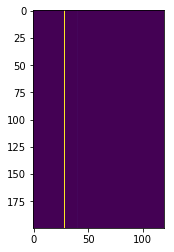

In [52]:
plt.imshow(o2)

In [33]:
type(out)

tuple

In [53]:
f = out[1]

In [54]:
f = f.data

In [55]:
f = f.cpu().numpy()

In [56]:
f.shape

(200, 1)

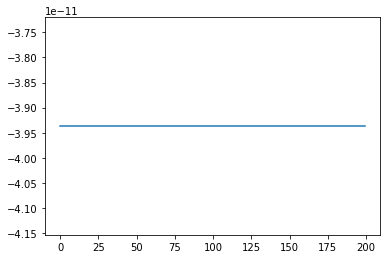

In [57]:
plt.plot(f)

In [58]:
o2.shape

(200, 120)

In [59]:
XX = o2 + np.sqrt(np.exp(f))*np.random.normal(size=(200,120))

In [60]:
XX.shape

(200, 120)

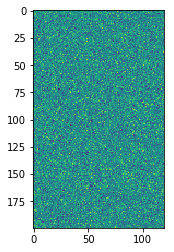

In [61]:
plt.imshow(XX)